<a href="https://colab.research.google.com/github/TheAmirHK/Experiments/blob/main/DistributedLearning_HandwritingRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import time
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# input
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [35]:
# Normal CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

start_time = time.time()
history = model.fit(x_train, y_train, epochs=5, validation_split=0.1, batch_size=64)
end_time = time.time()
training_time = end_time - start_time


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 52s 59ms/step - accuracy: 0.8864 - loss: 0.3795 - val_accuracy: 0.9823 - val_loss: 0.0560
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 81s 58ms/step - accuracy: 0.9835 - loss: 0.0528 - val_accuracy: 0.9883 - val_loss: 0.0414
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.9890 - loss: 0.0342 - val_accuracy: 0.9870 - val_loss: 0.0438
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 47s 56ms/step - accuracy: 0.9923 - loss: 0.0239 - val_accuracy: 0.9888 - val_loss: 0.0387
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 48s 57ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.9900 - val_loss: 0.0372


In [36]:
print(f"Normal training time: {training_time:.2f} seconds")

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Normal training time: 343.63 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9881 - loss: 0.0402
Test Accuracy: 0.99


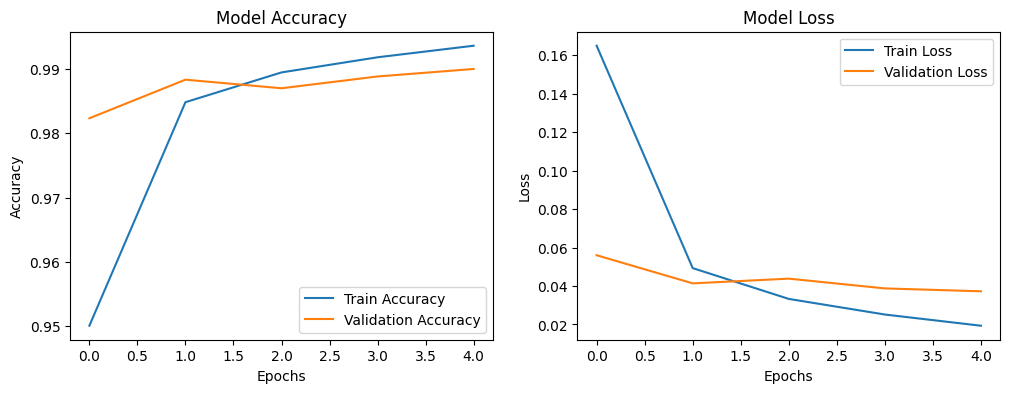

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


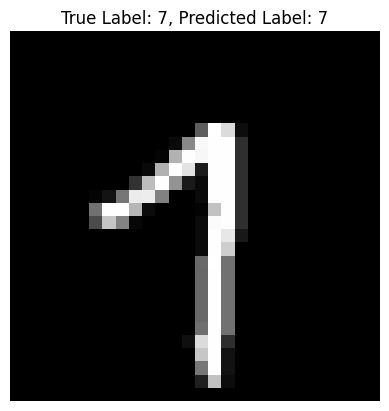

In [38]:
# test
sample_index = 4027  # a tricky one :)
sample_image = x_test[sample_index]
sample_label = np.argmax(y_test[sample_index])

prediction = model.predict(sample_image.reshape(1, 28, 28, 1))
predicted_label = np.argmax(prediction)

plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title(f"True Label: {sample_label}, Predicted Label: {predicted_label}")
plt.axis("off")
plt.show()


In [39]:
# Distributed CNN model
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')  # Output layer
    ])
    return model

# Use MirroredStrategy for multi-GPU training on a single machine
strategy = tf.distribute.MirroredStrategy()

print(f"Number of devices: {strategy.num_replicas_in_sync}")


# Build and compile the model within the strategy scope
with strategy.scope():
    dis_model = create_model()
    dis_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()
dis_history = dis_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1)
end_time = time.time()
dis_training_time = end_time - start_time


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Number of devices: 1
Epoch 1/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8517 - loss: 0.5344 - val_accuracy: 0.9608 - val_loss: 0.1474
Epoch 2/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9562 - loss: 0.1522 - val_accuracy: 0.9697 - val_loss: 0.1063
Epoch 3/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9700 - loss: 0.1023 - val_accuracy: 0.9748 - val_loss: 0.0916
Epoch 4/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9780 - loss: 0.0757 - val_accuracy: 0.9735 - val_loss: 0.0877
Epoch 5/5
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9824 - loss: 0.0603 - val_accuracy: 0.9763 - val_loss: 0.0811


In [40]:
print(f"Distributed training time: {dis_training_time:.2f} seconds")

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

Distributed training time: 31.81 seconds
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9881 - loss: 0.0402
Test Accuracy: 0.99


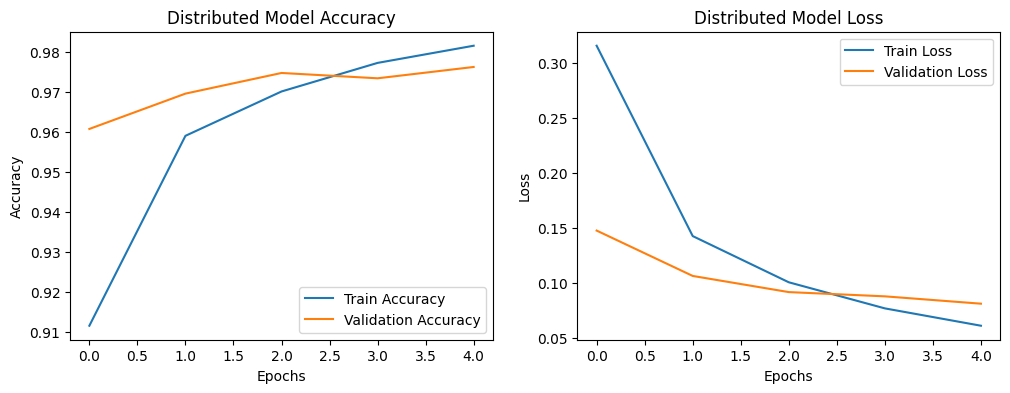

In [41]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(dis_history.history['accuracy'], label='Train Accuracy')
plt.plot(dis_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Distributed Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(dis_history.history['loss'], label='Train Loss')
plt.plot(dis_history.history['val_loss'], label='Validation Loss')
plt.title('Distributed Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


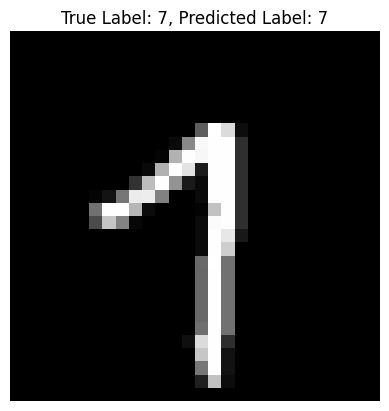

In [42]:
# Test the model with a sample image
sample_index = 4027 
sample_image = x_test[sample_index]
sample_label = np.argmax(y_test[sample_index])

# Predict using the model
prediction = dis_model.predict(sample_image.reshape(1, 28, 28, 1))
predicted_label = np.argmax(prediction)

# Plot the sample image with the prediction
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.title(f"True Label: {sample_label}, Predicted Label: {predicted_label}")
plt.axis("off")
plt.show()